## QCNN implementation

In [1]:
import matplotlib.pyplot as plt
from torchquantum.plugins import op_history2qasm
from source.models import *
from source.state_prep import *
from source.train_funcs import *
from tabulate import tabulate
from texttable import Texttable

### Calling model and training

In [3]:
n_qubits = 8
n_cycles = 4

circuit_builder = MajoranaCircuit
model = VQCNN_Parameterized(circuit_builder, n_qubits = n_qubits, n_cycles = n_cycles) # model that we're using
train_load, train_lab, test_load, test_lab = circuit_builder(n_qubits, n_cycles).generate_data(n_points=5, train_split=0.8)
model, preds, accuracy = train(model, train_load, train_lab, epochs=1, lr=5e-3)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.6801754236221313


### Model benchmarking

In [6]:
# hyperparameters
lr = 5e-3
epochs = 1
train_split = 0.8
n_points = 5

# params
n_qubits = 8
n_cycles = 4

# calling different models
models_to_benchmark = [QCNN_Base, QCNN_ZNOTY, Classical_NN, QCNN_Pure, QCNN_Shared, QCNN_Diff, QCNN_ZNOTY_Diff]

# getting train/test data
circuit_builder = MajoranaCircuit
model = QCNN_Base(circuit_builder, n_qubits, n_cycles)
train_load, train_lab, test_load, test_lab = circuit_builder(n_qubits, n_cycles).generate_data(n_points=n_points, train_split=train_split)

# objects to store results
train_acc = []
test_acc = []

# benchmarking models
for network in models_to_benchmark:
    model = network(circuit_builder)
    model, preds, train_accuracy = train(model, train_load, train_lab, epochs=epochs, lr=lr)
    preds, test_accuracy = test(model, test_load, test_lab)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.6679816842079163


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.606852114200592


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.8333927392959595


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.7687122821807861


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0, loss: 0.7133960723876953


  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: MajoranaCircuit.generate_circuit() missing 1 required positional argument: 'x'

Summarizing benchmarking results

In [6]:
rows = [['model', 'test acc', 'train acc', '# copies ', '# trainable params']]
table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)

for i, network in enumerate(models_to_benchmark):
    row = [str(network.__name__), str(test_acc[i]), str(train_acc[i]),str(0), str(0)]
    rows.append(row)

table.add_rows(rows)

print('\nTabulate Latex:')
print(tabulate(rows, headers='firstrow', tablefmt='latex'))


Tabulate Latex:
\begin{tabular}{lrrrr}
\hline
 model           &   test acc &   train acc &   \# copies  &   \# trainable params \\
\hline
 QCNN\_Base       &          0 &           0 &           0 &                    0 \\
 QCNN\_ZNOTY      &          0 &           0 &           0 &                    0 \\
 Classical\_NN    &          0 &           0 &           0 &                    0 \\
 QCNN\_Pure       &          0 &           0 &           0 &                    0 \\
 QCNN\_Shared     &          0 &           0 &           0 &                    0 \\
 QCNN\_Diff       &          0 &           0 &           0 &                    0 \\
 QCNN\_ZNOTY\_Diff &          0 &           0 &           0 &                    0 \\
\hline
\end{tabular}


### Testing the trained model

In [3]:
preds, accuracy = test(model, test_load, test_lab)
print(accuracy)

0.64


### Plot results and visualize phase diagram

Text(0.5, 1.0, 'QCNN classification (1 = trivial, 0 = topological)')

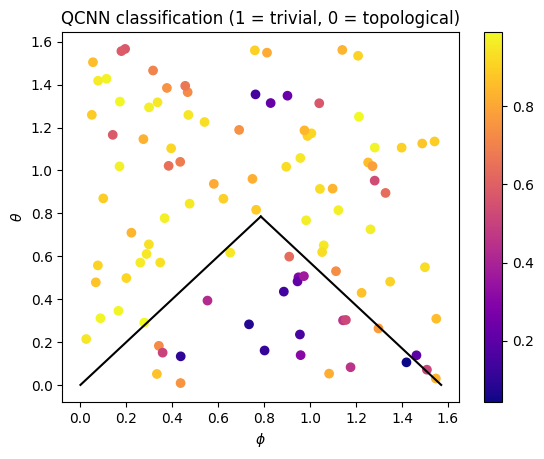

In [4]:
f, ax = plt.subplots()
phis = []
thetas = []
pred_s = []
for i, angles in enumerate(test_load):
    pred = preds[i].detach().numpy()
    theta = angles[0].detach().numpy()
    phi = angles[1].detach().numpy()
    phis.append(phi)
    thetas.append(theta)
    pred_s.append(pred)

points = ax.scatter(phis, thetas, c=pred_s,cmap='plasma')
f.colorbar(points)
ax.plot(np.linspace(0, np.pi/4, 50), np.linspace(0, np.pi/4, 50), c = 'k')
ax.plot(np.linspace(np.pi/4, np.pi/2, 50), np.ones(50)*np.pi/2-np.linspace(np.pi/4, np.pi/2, 50), c = 'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$')
ax.set_title('QCNN classification (1 = trivial, 0 = topological)')

In [5]:
# qiskit_circuit = op_history2qasm(qdev.n_wires, qdev.op_history)